In [2]:
import sys
import os
from pyproj import Proj, transform

#adding prognos tools
sys.path.insert(0, "/home/jose-luis/Envs/niva_prognos/PROGNOS/")
from prognos_tools.encrypt import decryptString,encryptString
from prognos_tools.Basin import Basin

# Creation of database containing processed dem for catchment delineation
## Creation of virtual machine with postgresql, postgis and plpgsql

In [3]:
machineInfo={}
#Vm characteristics
machineInfo['instance'] = 'svalbard'
machineInfo['username'] = 'jose-luis'
machineInfo['image'] = 'debian-9-stretch-v20190423'
machineInfo['imageProject'] = 'debian-cloud'
machineInfo['diskSize'] = '600GB'
machineInfo['keyDir'] = '/home/jose-luis/.ssh/hydrosvalbard'
machineInfo['region'] = 'europe-west3-a'
machineInfo['machineType'] = 'n1-standard-32'
#machineInfo['machineType'] = 'n1-highmem-16'
machineInfo['keyFile'] = F'{os.path.join(machineInfo["keyDir"],machineInfo["username"])}'
machineInfo['pubKeyFile'] = F'{machineInfo["keyFile"] + ".pub"}'

svalbard = Basin(machineInfo)

svalbard.vmScript = '''#!/bin/bash

sudo apt-get update

yes | sudo apt-get install postgresql postgresql-contrib postgis unzip git cmake g++ gcc libopenmpi-dev gdal-bin libgdal-dev python-gdal libfftw3-dev htop grass grass-dev libgdal-grass saga

export GCSFUSE_REPO=gcsfuse-`lsb_release -c -s`
echo "deb http://packages.cloud.google.com/apt $GCSFUSE_REPO main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

yes | sudo apt-get update
yes | sudo apt-get install gcsfuse

#Allowing ssh connection to server
sudo find /etc -name postgresql.conf -exec sudo sed -i s/.*listen_addresses.*/listen_addresses\\ =\\ \\'*\\'/g {} \;
sudo find /etc -name pg_hba.conf -exec sh -c "echo host all all 151.157.0.0/16 md5>> {}" \;
sudo service postgresql restart

#Creating user and geosvalbard database
sudo -u postgres createuser jose-luis
sudo -u postgres createdb geosvalbard
a=\\\\\\\"jose-luis\\\\\\\"
sudo su -c "psql -d geosvalbard -c \\"grant all privileges on database geosvalbard to $a;\\"" postgres
sudo su -c "psql -d geosvalbard -c \\"alter user $a with superuser;\\"" postgres
sudo su -c "psql -d geosvalbard -c \\"alter user $a with password 'kakaroto';\\"" postgres

#enable postgis on database
echo "ALTER DATABASE geosvalbard SET search_path=public, postgis, contrib, topology;" | psql -d geosvalbard
echo "ALTER DATABASE geosvalbard SET postgis.gdal_enabled_drivers = ENABLE_ALL;" | psql -d geosvalbard
echo "CREATE EXTENSION postgis CASCADE;" | psql -d geosvalbard
echo "CREATE EXTENSION postgis_topology CASCADE;" | psql -d geosvalbard
echo "ALTER DATABASE geosvalbard SET search_path=public, postgis, contrib, topology;" | psql -d geosvalbard
echo "ALTER DATABASE geosvalbard SET postgis.gdal_enabled_drivers = ENABLE_ALL;" | psql -d geosvalbard
echo "SELECT pg_reload_conf();" | psql -d geosvalbard
echo "SET postgis.enable_outdb_rasters TO True;" | psql -d geosvalbard
'''

Basin.initString += '''--scopes=https://www.googleapis.com/auth/devstorage.read_write'''

svalbard.instantiate(fabfile='fabfile.py')
print("The ip of the google cloud instance is {}".format(svalbard.ip))

#Testing connection to instance
svalbard.callPopen('gcloud compute ssh {username}@{instance} --zone {region}'.format(
**svalbard.machineInfo))

#Installing dependencies necessary to crawl through geonorge
scriptsFolder='./scripts'
svalbard.runScript(saveFolder=scriptsFolder,scriptName='setup.sh')


[35.246.145.162] out: ----------------
[35.246.145.162] out:  t
[35.246.145.162] out: (1 row)
[35.246.145.162] out: 
[35.246.145.162] out: SET
[35.246.145.162] out: 


Done.
Disconnecting from 35.246.145.162... done.



## Downloading elevation and river datasets

In [4]:
#Extracting a subset of the raster (around Adventelva)
adventelvaY,adventelvaX = 78.20486,15.81774
#Converting to epsg:3035
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3035')
x,y = transform(inProj,outProj,adventelvaX,adventelvaY)
offset=100000
box={'ulx': x - offset, 'uly': y + offset , 'lrx': x + offset , 'lry': y - offset }

svalbard.vmScript='''#!/bin/bash
#Getting 20m DEM
#wget http://publicdatasets.data.npolar.no/kartdata/NP_S0_DTM20.zip 
#unzip *.zip
#rm *.zip
#find ./ -name *.tif -exec mv {{}} svalbard20.tif \\;

#gdalwarp -s_srs EPSG:32633 -t_srs EPSG:3035 -r cubicspline -overwrite -srcnodata 0.0 -dstnodata -9999 svalbard20.tif svalbard20_3035.tif
#gdalwarp -s_srs EPSG:32633 -t_srs EPSG:4326 -r cubicspline -overwrite -srcnodata 0.0 -dstnodata -9999 svalbard20.tif svalbard20_4326.tif

rm -f svalbard20_3035_subset.tif
gdal_translate -projwin {ulx} {uly} {lrx} {lry} svalbard20_3035.tif svalbard20_3035_subset.tif
#gdalwarp -s_srs EPSG:3035 -t_srs EPSG:4326 -r cubicspline -overwrite -srcnodata -3.4028234663852886e+38 -dstnodata -9999 svalbard20_3035_subset.tif svalbard20_4326_subset.tif
#gdal_translate -of "Envi" svalbard20_4326_subset.tif ./LSDTopoTools/Git_projects/LSDTopoTools_ChannelExtraction/driver_functions_ChannelExtraction/svalbard.bil
#gdal_translate -of "AAIGrid" svalbard20_4326_subset.tif ./LSDTopoTools/Git_projects/LSDTopoTools_ChannelExtraction/driver_functions_ChannelExtraction/svalbard.ascii

#Getting rivers
#wget https://nedlasting.geonorge.no/api/download/order/a867cb2b-c1bb-43dc-9939-6f7365754d29/224b3a20-4572-4f79-ad77-440509dabae5-O svalbard.zip
#unzip svalbard.zip #&& mv NP_S100_SOS svalbard

#Getting sosicon
#wget https://github.com/espena/sosicon/blob/master/bin/cmd/linux64/sosicon?raw=true -O sosicon && chmod +x sosicon && mv sosicon ./svalbard/
'''.format(**box)

#Installing dependencies necessary to crawl through geonorge
scriptsFolder='./scripts'
svalbard.runScript(saveFolder=scriptsFolder,scriptName='getSvalbard.sh')


[35.246.145.162] put: ./scripts/getSvalbard.sh -> getSvalbard.sh
[35.246.145.162] run: chmod +x getSvalbard.sh
[35.246.145.162] run: ./getSvalbard.sh
[35.246.145.162] out: Input file size is 25786, 36896
[35.246.145.162] out: 0...10...20...30...40...50...60...70...80...90...100 - done.
[35.246.145.162] out: 


Done.
Disconnecting from 35.246.145.162... done.



## Installing Taudem

In [4]:
svalbard.vmScript = '''#!/bin/bash
mkdir -p taudem
git clone https://github.com/dtarb/TauDEM.git --branch master --single-branch ./taudem
cd taudem/src
mkdir build && cd build
cmake ..
make
sudo make install
cd ~

#Installing lsdtopotools
#git clone https://github.com/LSDtopotools/LSDTopoTools2.git
#cd LSDTopoTools2
#sh lsdtt2_setup.sh

#wget https://raw.githubusercontent.com/LSDtopotools/LSDAutomation/master/LSDTopoToolsSetup.py
#python LSDTopoToolsSetup.py -id 1 -CE True

'''
#Cloning and installing taudem
scriptsFolder='./scripts'
svalbard.runScript(saveFolder=scriptsFolder,scriptName='getTaudem.sh')


[35.246.234.243] out: -- Set runtime path of "/usr/local/bin/streamnet" to ""
[35.246.234.243] out: -- Installing: /usr/local/bin/threshold
[35.246.234.243] out: -- Set runtime path of "/usr/local/bin/threshold" to ""
[35.246.234.243] out: -- Installing: /usr/local/bin/gagewatershed
[35.246.234.243] out: -- Set runtime path of "/usr/local/bin/gagewatershed" to ""
[35.246.234.243] out: 


Done.
Disconnecting from 35.246.234.243... done.



## Pre-processing dem

In [5]:
svalbard.vmScript = '''#!/bin/bash
n=`nproc`
rm fel.tif
rm flow_dir.tif
rm flow_acc.tif
rm streams.tif
rm river*
rm fa.tif

mpiexec -n $n pitremove -z svalbard20_3035_subset.tif -fel fel.tif
mpiexec -n $n d8flowdir -fel fel.tif -p flow_dir.tif
mpiexec -n $n aread8 -p flow_dir.tif -nc -ad8 flow_acc.tif
mpiexec -n $n threshold -ssa flow_acc.tif -thresh 800 -src streams.tif

cp flow_acc.tif fa.tif
gdal_edit.py fa.tif -unsetnodata
gdal_calc.py -A fa.tif --overwrite --outfile=river.tif --calc="A>2500 * logical_not(A==-9999)" --type Byte
gdal_translate -co "NBITS=1" river.tif bit_river.tif

rm fel.tif
rm flow_dir.tif
rm flow_acc.tif
rm streams.tif
rm river.tif
rm fa.tif
rm el.tif

gdal_calc.py -A svalbard20_3035_subset.tif -B bit_river.tif --outfile=el.tif --calc="A-B*10" 
mpiexec -n $n pitremove -z el.tif -fel fel.tif
mpiexec -n $n d8flowdir -fel fel.tif -p flow_dir.tif
mpiexec -n $n aread8 -p flow_dir.tif -nc -ad8 flow_acc.tif

rm bit_river.tif

cp flow_acc.tif fa.tif
gdal_edit.py fa.tif -unsetnodata
gdal_calc.py -A fa.tif --overwrite --outfile=river.tif --calc="A>2500 * logical_not(A==-9999)" --type Byte
gdal_translate -co "NBITS=1" river.tif bit_river.tif

saga_cmd imagery_segmentation "Grid Skeletonization" -INPUT bit_river.tif -METHOD 0 -INIT_METHOD 1 -INIT_THRESHOLD 0 -CONVERGENCE 0 -VECTOR "./river.shp"
'''
#Cloning and installing taudem
scriptsFolder='./scripts'
svalbard.runScript(saveFolder=scriptsFolder,scriptName='preProcessDEM.sh')


[35.246.145.162] out:  96%
[35.246.145.162] out:  97%
[35.246.145.162] out:  98%
[35.246.145.162] out:  99%
[35.246.145.162] out: 100%okay
[35.246.145.162] out: 


Done.
Disconnecting from 35.246.145.162... done.



## Uploading flow_direction and elevation rasters to database


In [6]:
svalbard.vmScript = '''#!/bin/bash
echo "DROP SCHEMA svalbard CASCADE;" | psql -d geosvalbard
echo "CREATE SCHEMA svalbard;" | psql -d geosvalbard
#Putting rivers in database
shp2pgsql -I -d -s 3035 river.shp svalbard.rivers | psql -q -d geosvalbard
#Putting rasters in database
raster2pgsql -I -M -F -b 1 -r -s 3035 -d -t auto flow_dir.tif  svalbard.flow_dir | psql -q -d geosvalbard
raster2pgsql -I -M -F -b 1 -r -s 3035 -d -t auto svalbard20_3035_subset.tif  svalbard.el | psql -q -d geosvalbard

echo "SELECT procedures.setExtentTable('svalbard','flow_dir');" | psql -d geosvalbard
echo "SELECT procedures.setExtentTable('svalbard','el');" | psql -d geosvalbard

'''

svalbard.runScript(saveFolder=scriptsFolder,scriptName='uploadRasters.sh')


[35.246.145.162] out:  setextenttable 
[35.246.145.162] out: ----------------
[35.246.145.162] out:  
[35.246.145.162] out: (1 row)
[35.246.145.162] out: 
[35.246.145.162] out: 


Done.
Disconnecting from 35.246.145.162... done.



### Setting up procedures on geodatabase

In [64]:
svalbard.vmScript = '''#!/bin/bash
read -r -d '' sql <<-EOM
DROP SCHEMA IF EXISTS procedures CASCADE;
CREATE SCHEMA procedures;
CREATE EXTENSION IF NOT EXISTS plsh;
DROP TYPE IF EXISTS station_info CASCADE;  
CREATE TYPE station_info AS (
station_name varchar(80),
station_id INTEGER,
longitude DOUBLE PRECISION,
latitude DOUBLE PRECISION,
buffer DOUBLE PRECISION,    
epsg INTEGER,
mask TEXT
);
EOM

echo $sql | psql -d geosvalbard
'''
svalbard.runScript(saveFolder=scriptsFolder,scriptName='initDB.sh')

svalbard.vmScript = '''#!/bin/bash
read -r -d '' sql <<-EOM1
CREATE OR REPLACE FUNCTION procedures.initializeStations() RETURNS void AS \$\$
BEGIN
    DROP TABLE IF EXISTS procedures.stations;                       
    CREATE TABLE procedures.stations( 
                                     sid SERIAL PRIMARY KEY,
                                     station_name varchar(80) UNIQUE,
                                     station_id INTEGER UNIQUE,
                                     longitude DOUBLE PRECISION,
                                     latitude DOUBLE PRECISION,
                                     geom geometry(POINT,3035),
                                     mask geometry(POLYGON,3035)
                                    );                       
  RETURN;
END; 
\$\$ LANGUAGE PLPGSQL;
EOM1
echo $sql | psql -d geosvalbard

read -r -d '' sql <<-EOM2
 CREATE OR REPLACE FUNCTION procedures.initializeSchema( _schema text  ) RETURNS void AS \$\$
BEGIN
    EXECUTE 'DROP SCHEMA IF EXISTS ' || _schema || ' CASCADE';
    EXECUTE 'CREATE SCHEMA ' || _schema;
RETURN;
END; 
\$\$ LANGUAGE PLPGSQL;  
EOM2
echo $sql | psql -d geosvalbard

read -r -d '' sql <<-EOM3
CREATE OR REPLACE FUNCTION procedures.initializeResultsSchema( _schema text  ) RETURNS void AS \$\$
BEGIN
    EXECUTE 'DROP SCHEMA IF EXISTS ' || _schema || ' CASCADE';
    EXECUTE 'CREATE SCHEMA ' || _schema;
    EXECUTE 'ALTER TABLE procedures.stations
    SET SCHEMA ' || _schema;
RETURN;
END; 
\$\$ LANGUAGE PLPGSQL;
EOM3
echo $sql | psql -d geosvalbard

read -r -d '' sql <<-EOM4
CREATE OR REPLACE FUNCTION procedures.addStations( _station_array station_info[] ) RETURNS void AS \$\$
DECLARE 
    element station_info;
BEGIN
    FOREACH element IN ARRAY _station_array
    LOOP
        IF element.mask = '' THEN
            INSERT INTO procedures.stations(station_name, station_id, longitude, latitude, mask) 
            VALUES( element.station_name,
                    element.station_id,
                    element.longitude,
                    element.latitude,
                    ST_Buffer(ST_Transform(ST_SetSRID( ST_MakePoint(
                    element.longitude,element.latitude) , element.epsg ), 3035), element.buffer)
            );
        ELSE
            INSERT INTO procedures.stations(station_name, station_id, longitude, latitude, mask) 
            VALUES( element.station_name,
                    element.station_id,
                    element.longitude,
                    element.latitude,
                    ST_Transform(ST_GeomFromText( element.mask, element.epsg), 3035));
        END IF;

    END LOOP;
    UPDATE procedures.stations
    SET geom=ST_Transform(ST_SetSRID(ST_MakePoint(longitude,latitude),element.epsg),3035);
    CREATE INDEX stations_idx ON procedures.stations USING GIST(geom);

RETURN;
END; 
\$\$ LANGUAGE PLPGSQL;
EOM4
echo $sql | psql -d geosvalbard

read -r -d '' sql <<-EOM5
CREATE OR REPLACE FUNCTION procedures.setExtentTable( _schema text, _table text ) RETURNS void AS \$\$
BEGIN
    EXECUTE 'ALTER TABLE ' || _schema || '.' || _table ||
             ' ADD COLUMN extent geometry(POLYGON, 3035);'; 

    EXECUTE 'UPDATE ' ||_schema || '.' || _table ||
            ' SET extent = St_Envelope(rast);';

    EXECUTE 'CREATE INDEX extent_'|| _table ||'_idx ON ' ||_schema || '.' || _table ||' USING GIST(extent);';        

RETURN;
END; 
\$\$ LANGUAGE PLPGSQL; 
EOM5
echo $sql | psql -d geosvalbard

read -r -d '' sql <<-EOM6
CREATE OR REPLACE FUNCTION procedures.generateBaseData(_schema text, st_rast text, st_shp text) RETURNS void AS \$\$
DECLARE
   resultsTableRast text = st_rast;
   resultsTableShp text = st_shp;
BEGIN
   EXECUTE 'DROP TABLE IF EXISTS bufferTable;';

   EXECUTE 'CREATE TEMP TABLE bufferTable AS 
            SELECT a.station_id,
                   a.station_name,
                   a.mask as limits,
                   a.geom as outlet 
            FROM ' || _schema || '.stations AS a;';

   EXECUTE 'CREATE INDEX buffer_idx ON bufferTable USING GIST(limits);';

   EXECUTE 'INSERT INTO ' || resultsTableRast || '(station_id, 
                                                   station_name, 
                                                   idx 
                                                   ) 
            SELECT buffer.station_id, 
                   buffer.station_name,
                   raster.rid 
                   FROM svalbard.flowdir AS raster, bufferTable as buffer 
                   WHERE ST_Intersects(raster.extent, buffer.limits) ;'; 

   EXECUTE 'INSERT INTO ' || resultsTableShp || '(station_id, 
                                                  station_name, 
                                                  limits, 
                                                  outlet 
                                                  ) 
            SELECT buffer.station_id, 
                   buffer.station_name,
                   buffer.limits,
                   buffer.outlet
                   FROM bufferTable as buffer;';                                 

   EXECUTE 'CREATE VIEW basins.flow AS
                SELECT b.station_id,a.rast FROM svalbard.flowdir as a
                INNER JOIN ' || resultsTableRast ||' AS b
                ON a.rid=b.idx;';

   EXECUTE 'CREATE VIEW basins.elevation AS
                SELECT b.station_id,a.rast FROM svalbard.elevation as a
                INNER JOIN ' || resultsTableRast ||' AS b
                ON a.rid=b.idx;';  

   EXECUTE ' WITH buffer AS (SELECT ST_Buffer(outlet,500) AS around FROM ' || resultsTableShp || ')
             UPDATE ' || resultsTableShp ||
           ' SET rivers = (SELECT ST_Union(ST_Intersection(b.around,a.geom)) 
             FROM svalbard.rivers AS a , buffer AS b
             WHERE ST_Intersects(b.around,a.geom));';

   EXECUTE 'UPDATE ' || resultsTableShp || 'SET outlet = ST_ClosestPoint(rivers,outlet);';
RETURN;
END;
\$\$ LANGUAGE PLPGSQL;   
EOM6
echo $sql | psql -d geosvalbard


read -r -d '' sql <<-EOM7
CREATE OR REPLACE FUNCTION procedures.createDataTable( _schema text, _table text ) RETURNS void AS \$\$
DECLARE 
    st_rast text = _schema || '.' || _table || 'Rast';
    st_shp text = _schema || '.' || _table  || 'Shp';
    st text = _schema || '.' || _table ;
    stations text = _schema || '.stations';
    s text = _schema;
    t text = _table;
BEGIN
    EXECUTE 'CREATE TABLE ' || st_rast || '(sid SERIAL PRIMARY KEY, 
                                            station_id INTEGER REFERENCES ' || stations || '(station_id), 
                                            station_name varchar(80) REFERENCES ' || stations || '(station_name),
                                            idx INTEGER
                                            );'; 

     EXECUTE 'CREATE TABLE ' || st_shp || '(sid SERIAL PRIMARY KEY, 
                                            station_id INTEGER REFERENCES ' || stations || '(station_id), 
                                            station_name varchar(80) REFERENCES ' || stations || '(station_name),
                                            rivers geometry(MULTILINESTRINGZ, 3035 ), 
                                            limits geometry(POLYGON, 3035), 
                                            outlet geometry(POINT, 3035));';      


    EXECUTE 'SELECT procedures.generateBaseData('' '|| s ||' '','' '|| st_rast ||' '', '' '|| st_shp ||' '');';     
RETURN;
END; 
\$\$ LANGUAGE PLPGSQL;
EOM7
echo $sql | psql -d geosvalbard




read -r -d '' sql <<-EOM8
CREATE OR REPLACE FUNCTION procedures.createResultsTable( _schema text, _table text) RETURNS void AS \$\$
 DECLARE 
     st_rast text = _schema || '.' || _table || 'Rast';
     st_shp text = _schema || '.' || _table || 'Shp';
     stations text = _schema || '.stations';
 BEGIN
     EXECUTE 'CREATE TABLE ' || st_rast || '(sid SERIAL PRIMARY KEY, station_id INTEGER, 
     station_name varchar(80),
     rast raster);';
     EXECUTE 'CREATE TABLE ' || st_shp || '(sid SERIAL PRIMARY KEY, station_id INTEGER, 
     station_name varchar(80),
     basin geometry(MULTIPOLYGON, 3035));';
 RETURN;
 END; 
\$\$ LANGUAGE PLPGSQL; 
EOM8
echo $sql | psql -d geosvalbard
'''
#Cloning and installing taudem
scriptsFolder='./scripts'
#svalbard.runScript(saveFolder=scriptsFolder,scriptName='initDB.sh')



[35.246.234.243] out: CREATE FUNCTION
[35.246.234.243] out: CREATE FUNCTION
[35.246.234.243] out: CREATE FUNCTION
[35.246.234.243] out: CREATE FUNCTION
[35.246.234.243] out: CREATE FUNCTION
[35.246.234.243] out: 


Done.
Disconnecting from 35.246.234.243... done.



### Creating yaml file with stations list

In [14]:
import yaml

coords=[
{'name': 'Adventelva', 'latitude': 78.20388, 'longitude': 15.82857, 'id':1},
{'name': 'Endalselva', 'latitude': 78.200545, 'longitude': 15.816164, 'id':2},
{'name': 'Todalselva', 'latitude': 78.17167, 'longitude': 15.86485, 'id':3},    
{'name': 'Bolterelva', 'latitude': 78.16333, 'longitude': 15.98027, 'id':4},
{'name': 'Foxelva',    'latitude': 78.15919, 'longitude': 16.20452, 'id':5},
{'name': 'AdventelvaSea', 'latitude': 78.2272992, 'longitude': 15.7447349, 'id': 6}, 
{'name': 'DeGeerelva',    'latitude': 78.33822, 'longitude': 16.31238, 'id':7},
{'name': 'Sassenelva',    'latitude': 78.33203, 'longitude': 16.86129, 'id':8},
{'name': 'Gipsdalselva',  'latitude': 78.44082, 'longitude': 16.57706, 'id':9},
{'name': 'Ebbaelva',      'latitude': 78.70824, 'longitude': 16.599771, 'id':10}
]


#{'name': 'Endalselva', 'latitude': 78.19590, 'longitude': 15.81446, 'id':2},
coords=[{'station': {'station_name': i['name'].strip(),
                        'station_id': i['id'],
                        'longitude': i['longitude'],
                        'latitude': i['latitude'],
                        'epsg': 4326,
                        'buffer': 50000
                       }
          } for i in coords
       ]

with open('adventselva.yaml','w') as f:
    f.write(yaml.dump(coords,allow_unicode=True))

    
def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            return False 

def infoToString(d):
    l = [ "'"+d[key]+"'" if isinstance(d[key],str) else str(d[key])  for key in ['station_name','station_id','longitude','latitude','buffer','epsg','limits']]
    return 'row(' + ','.join(l) +')::station_info'

def yamlToInfoArray(yamlFile):
    allStations = list()
    stations = yaml.safe_load(open(yamlFile))
    for i in stations:
        data = i['station']
        if is_number(data['buffer']):
            data['limits'] = ''
        else:
            data['buffer'] = -9999
        allStations.append(data)
    return 'ARRAY[' +  ','.join([infoToString(i) for i in allStations]) + ']', ' '.join([str(i['station_id']) for i in allStations]);

array,ids = yamlToInfoArray('adventselva.yaml')
display(array,ids)

"ARRAY[row('Adventelva',1,15.82857,78.20388,50000,4326,'')::station_info,row('Endalselva',2,15.816164,78.200545,50000,4326,'')::station_info,row('Todalselva',3,15.86485,78.17167,50000,4326,'')::station_info,row('Bolterelva',4,15.98027,78.16333,50000,4326,'')::station_info,row('Foxelva',5,16.20452,78.15919,50000,4326,'')::station_info,row('AdventelvaSea',6,15.7447349,78.2272992,50000,4326,'')::station_info,row('DeGeerelva',7,16.31238,78.33822,50000,4326,'')::station_info,row('Sassenelva',8,16.86129,78.33203,50000,4326,'')::station_info,row('Gipsdalselva',9,16.57706,78.44082,50000,4326,'')::station_info,row('Ebbaelva',10,16.599771,78.70824,50000,4326,'')::station_info]"

'1 2 3 4 5 6 7 8 9 10'

In [15]:
svalbard.vmScript='''#!/bin/bash
#Initializing schema for basin processing
read -r -d '' SQL <<- EOM
SELECT procedures.initializeStations();
SELECT procedures.addStations({2});
SELECT procedures.initializeResultsSchema('{0}');
SELECT procedures.createDataTable('{0}','dem');
SELECT procedures.createResultsTable('{0}','results');
EOM
echo $SQL | psql -d geosvalbard
# Processing basin for station with station_id id     
for id in {1}
do
  echo $id
  rm -rf Trash${{id}}
  mkdir Trash${{id}}
  cd Trash${{id}}

  #Exporting outlets from database as a shapefile
  pgsql2shp -g outlet -f stations${{id}} geosvalbard "select station_name, station_id, outlet  from {0}.demshp where station_id=${{id}}"
  
  #Computing basing using TauDEM. This produces a boolean tif where true means the cell is upstream of the outlet (i.e. part of the basin)
  n=`nproc`
  mpiexec -n $n gagewatershed -p "PG:dbname=geosvalbard schema={0} table=flow column=rast where='station_id=${{id}}' mode=2" -o stations${{id}}.shp -gw watershed${{id}}.tif

  #Transforming upstream pixels to shapefile
  gdal_polygonize.py -f "ESRI Shapefile" watershed${{id}}.tif basin${{id}}.shp

  #Uploading the basin shapefile to the database
  shp2pgsql -S -d -s 3035 basin${{id}}.shp {0}.dummy | psql -d geosvalbard   
  
  #Placing the basin shapefile in the results table    
  read -r -d '' SQL <<- EOM
      INSERT INTO {0}.resultsShp(station_id,station_name,basin)
      SELECT b.station_id, b.station_name, ST_MakeValid(ST_Multi(ST_Union(a.geom)))
      FROM {0}.stations AS b, {0}.dummy AS a
      WHERE b.station_id=${{id}}
      GROUP BY station_id, station_name;
EOM
  echo $SQL | psql -d geosvalbard

  cd $startDir
  rm -rf Trash${{id}}
done

echo "DROP TABLE IF EXISTS {0}.dummy;" | psql -d geosvalbard

#Getting extent of basin and saving it to a txt file on the server
IFS=$'\\n' read -r -d '' SQL <<- EOM
    (SELECT station_name,Box2D(ST_Transform(St_Buffer(St_Envelope(basin),2000),4326)) FROM {0}.resultsShp)
EOM
echo "\COPY "$SQL" TO '/home/jose-luis/results.txt' DELIMITER ';';" | psql -d geosvalbard
'''.format('test',ids,array)

svalbard.runScript(saveFolder=scriptsFolder,scriptName='getBasins.sh')


[35.246.145.162] out: COMMIT
[35.246.145.162] out: ANALYZE
[35.246.145.162] out: INSERT 0 1
[35.246.145.162] out: DROP TABLE
[35.246.145.162] out: COPY 10
[35.246.145.162] out: 


Done.
Disconnecting from 35.246.145.162... done.



### Getting elevation

In [9]:
svalbard.vmScript='''#! /bin/bash
read -r -d '' sql <<-EOM
CREATE OR REPLACE FUNCTION procedures.getElevation(_table text,_station text) RETURNS void AS \$\$ 
DECLARE
  table_name text := 'test.' || _table;
  station  text := _station;
BEGIN 
  EXECUTE 'DROP TABLE IF EXISTS subdivided;';
  EXECUTE FORMAT('CREATE TEMP TABLE subdivided AS 
                  SELECT ST_Subdivide(basin,256) AS geom 
                  FROM test.resultsshp AS a 
                  WHERE a.station_name=%s;', \'\'\'\' || station || \'\'\'\' );
  EXECUTE 'DROP INDEX IF EXISTS subdivided_idx';
  EXECUTE 'CREATE INDEX subdivided_idx ON subdivided USING GIST(geom)';
  
  EXECUTE 'DROP TABLE IF EXISTS elevData';
  EXECUTE FORMAT('CREATE TEMP TABLE elevData AS 
                  SELECT ST_DumpAsPolygons(rast) AS geo 
                  FROM test.resultsshp AS a, svalbard.el as b 
                  WHERE ST_Intersects(b.extent,a.basin) 
                  AND a.station_name=%s',\'\'\'\' || station || \'\'\'\');
  EXECUTE 'DROP INDEX IF EXISTS elevData_idx;';
  EXECUTE 'CREATE INDEX elevData_idx ON elevData USING GIST(((elevData.geo).geom));';
  
  EXECUTE FORMAT('DROP TABLE IF EXISTS %s;',table_name);
  EXECUTE FORMAT('CREATE TABLE %s(id SERIAL PRIMARY KEY, elev DOUBLE PRECISION, geom GEOMETRY(POLYGON,3035));', table_name);
  EXECUTE FORMAT('INSERT INTO %s(elev,geom) 
                  SELECT DISTINCT (a.geo).val, (a.geo).geom 
                  FROM elevData AS a, subdivided AS b 
                  WHERE ST_Intersects(b.geom,(a.geo).geom);', table_name);
  
  EXECUTE 'DROP TABLE IF EXISTS toRemove;';
  EXECUTE 'CREATE TEMP TABLE toRemove(id INTEGER, geom GEOMETRY(POLYGON,3035));';
  EXECUTE FORMAT('WITH myLine AS (SELECT ST_Boundary(basin) AS geom FROM test.resultsshp AS a WHERE a.station_name=%s) 
                  INSERT INTO toRemove(id,geom)
                  SELECT a.id,a.geom 
                  FROM %s AS a, myLine AS b
                  WHERE ST_Intersects(a.geom,b.geom);', \'\'\'\' || station || \'\'\'\', table_name);
  
  EXECUTE 'DROP TABLE IF EXISTS intersections;';
  EXECUTE 'CREATE TEMP TABLE intersections AS
           SELECT a.id, SUM(ST_Area(ST_Intersection(a.geom,b.geom))) AS suma
           FROM subdivided AS b, toRemove AS a
           WHERE ST_Intersects(a.geom,b.geom)
           GROUP by a.id;';
  
  EXECUTE FORMAT('DELETE FROM %s AS A USING intersections AS b WHERE a.id=b.id AND b.suma < 0.1;', table_name);
  
  RETURN;
END;
\$\$ LANGUAGE PLPGSQL;
EOM

echo $sql | psql -d geosvalbard
'''

svalbard.runScript(saveFolder=scriptsFolder,scriptName='queryBasinElevation.sh')


[35.246.145.162] Executing task 'setup'
[35.246.145.162] put: ./scripts/queryBasinElevation.sh -> queryBasinElevation.sh
[35.246.145.162] run: chmod +x queryBasinElevation.sh
[35.246.145.162] run: ./queryBasinElevation.sh
[35.246.145.162] out: CREATE FUNCTION
[35.246.145.162] out: 


Done.
Disconnecting from 35.246.145.162... done.



In [11]:
import pandas as pd
import numpy as np


stations = yaml.safe_load(open('adventselva.yaml'))
def cdf(x, plot=True, *args, **kwargs):
    x, y = (sorted(x) - min(x)) / (max(x) - min(x)), np.arange(len(x)) / len(x)
    #plt.plot(y, x, *args, **kwargs) if plot else (x, y)
    #plt.xlim([1.01,-0.01])
    return x,y

def getElevation(table,station):
    svalbard.vmScript='''#! /bin/bash
echo "SELECT procedures.getElevation(\'{0}\',\'{1}\');" | psql -d geosvalbard
echo "\COPY (SELECT elev from test.{0}) TO \'/home/jose-luis/dummy.txt\' DELIMITER \',\';" | psql -d geosvalbard
'''.format(table,station)
   
    svalbard.runScript(saveFolder=scriptsFolder,scriptName='dummy.sh')
    svalbard.callPopen('fab -f /home/jose-luis/Envs/niva_prognos/PROGNOS/prognos_tools/fabfile.py downloadFile:dummy.txt,dummy.txt'.format(station))
    elevation = pd.read_csv('dummy.txt'.format(station), header=None, names=['Elevation',])
    return elevation

cnt = False
ecdf = dict()
for i in stations:
    station = i['station']['station_name']
    elevation = getElevation(station + 'Elev',station)   
    x,y=cdf(elevation.Elevation.values)
    ecdf[station]= {'x': x, 'y': y}
    elevation.rename(columns={'Elevation':station},inplace=True)
    if not cnt:
        info = elevation.describe()
        cnt = True
    else:
        dummy = elevation.describe()
        info = pd.concat([info, dummy], axis=1, join='inner')

        
display(info)
info.to_csv('elevationInfo.txt')


[35.246.145.162] out: --------------
[35.246.145.162] out:  
[35.246.145.162] out: (1 row)
[35.246.145.162] out: 
[35.246.145.162] out: COPY 137855
[35.246.145.162] out: 


Done.
Disconnecting from 35.246.145.162... done.

[35.246.145.162] Executing task 'downloadFile'
[35.246.145.162] download: /home/jose-luis/Envs/niva_prognos/PROGNOS/notebooks/createGeodatabase/dummy.txt <- /home/jose-luis/dummy.txt

Done.
Disconnecting from 35.246.145.162... done.




,Adventelva,Endalselva,Todalselva,Bolterelva,Foxelva,AdventelvaSea,DeGeerelva,Sassenelva,Gipsdalselva,Ebbaelva
count,1.079153e+06,77329.000000,90592.000000,92942.000000,64714.000000,1.280943e+06,204311.000000,22857.000000,578829.000000,137855.000000
mean,4.393810e+02,452.162276,484.637470,508.335542,546.297248,4.335738e+02,412.128910,76.982761,386.733115,504.490809
std,2.500536e+02,239.058750,204.604542,205.194718,206.496521,2.532784e+02,217.572433,97.399792,262.004308,258.192827
min,3.224963e+00,3.983034,49.152260,56.953365,98.371750,7.024645e-01,9.694341,0.516186,0.902945,0.439645
25%,2.226992e+02,270.074493,351.762215,363.802429,393.475090,2.156609e+02,234.671982,3.109151,131.582825,325.532318
50%,4.483421e+02,478.561554,500.938812,527.574677,562.466034,4.457016e+02,404.384613,24.780209,396.923218,556.465210
75%,6.376415e+02,610.776428,603.768387,669.582642,717.590591,6.318274e+02,570.898193,157.143204,593.965515,692.779785
max,1.143694e+03,1020.984863,1021.318420,966.332947,1012.748657,1.143694e+03,991.560669,477.400085,1117.072998,1119.646973


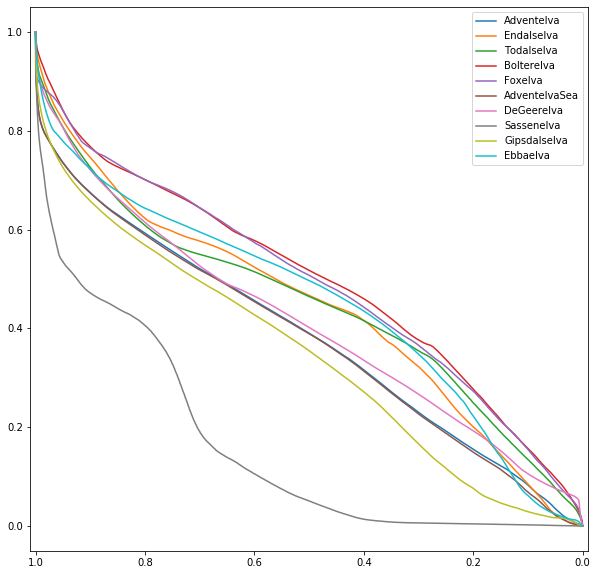

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for key, values in ecdf.items(): 
    plt.plot(values['y'],values['x'],label=key)
    
plt.xlim([1.01,-0.01])
plt.legend(loc='upper right')

plt.savefig('hypsogram.png')
